# Evaluate

In this notebook we evaluate the accuracy of the predicted alignments.

In [11]:
%matplotlib inline

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import os.path
import pandas as pd
import pickle

In [13]:
ANNOTATIONS_ROOT = Path('../Chopin_Mazurkas/annotations_beat')
query_list = Path('./cfg_files/query.train.list')

### Evaluate hypothesis directory

First evaluate a single hypothesis directory.

In [14]:
def eval_dir(hypdir, querylist, hop_sec, savefile = None):
    
    allErrs = {}
    cnt = 0
    print(f'Processing {hypdir} ', end='')
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
            allErrs[basename] = eval_file(hypfile, hop_sec)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
    print(' done')
    if savefile:
        print("Saving file: ", savefile)
        pickle.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs

In [15]:
def eval_file(hypfile, hop_sec):
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    annotfile1 = (ANNOTATIONS_ROOT / piece / parts[0]).with_suffix('.beat')
    annotfile2 = (ANNOTATIONS_ROOT / piece / parts[1]).with_suffix('.beat')
    gt1 = getTimestamps(annotfile1)
    gt2 = getTimestamps(annotfile2)
    hypalign = loadAlignment(hypfile) # warping path in frames
    if hypalign is None:
        err = [] # no valid path
    else:
        pred2 = np.interp(gt1, hypalign[0,:]*hop_sec, hypalign[1,:]*hop_sec)
        err = pred2 - gt2
    return err

In [16]:
def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

In [17]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])

In [18]:
def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pickle.load(f)
    return d

Evaluate a single hypothesis directory.

In [19]:
hypdir = 'experiments_train/online_250_clean'
savefile = 'evaluations_train/online_250_clean.pkl'
hop_sec = 512 * 1 / 22050
allErrs = eval_dir(hypdir, query_list, hop_sec, savefile)

Processing experiments_train/online_250_clean XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

FileNotFoundError: [Errno 2] No such file or directory: 'evaluations_train/online_250_clean.pkl'

Evaluate all hypothesis directories.

In [29]:
def eval_all_dirs(rootdir, querylist, hop_sec, outdir):
    print("entered eval_all_dirs")
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    for hypdir in glob.glob(f'{rootdir}/onlineDTW_*'):
        savefile = outdir + '/' + os.path.basename(hypdir) + '.pkl'
        print("eval all dirs - current savefile:")
        allErrs = eval_dir(hypdir, querylist, hop_sec, savefile = savefile)

In [30]:
EXPERIMENTS_ROOT = 'experiments_train'
hop_sec = 512 * 1 / 22050
outdir = 'evaluations_train'
eval_all_dirs(EXPERIMENTS_ROOT, query_list, hop_sec, outdir)

entered eval_all_dirs
eval all dirs - current savefile:
Processing experiments_train/onlineDTW_250_clean ... done
Saving file:  evaluations_train/onlineDTW_250_clean.pkl
eval all dirs - current savefile:
Processing experiments_train/onlineDTW_1000_clean ... done
Saving file:  evaluations_train/onlineDTW_1000_clean.pkl
eval all dirs - current savefile:
Processing experiments_train/onlineDTW_500_clean ... done
Saving file:  evaluations_train/onlineDTW_500_clean.pkl
eval all dirs - current savefile:
Processing experiments_train/onlineDTW_2000_clean ... done
Saving file:  evaluations_train/onlineDTW_2000_clean.pkl
eval all dirs - current savefile:
Processing experiments_train/onlineDTW_400_clean ... done
Saving file:  evaluations_train/onlineDTW_400_clean.pkl
eval all dirs - current savefile:
Processing experiments_train/onlineDTW_4000_clean ... done
Saving file:  evaluations_train/onlineDTW_4000_clean.pkl
eval all dirs - current savefile:
Processing experiments_train/onlineDTW_8000_clean 

EOFError: Ran out of input

### Plot error vs tolerance

In [31]:
def calc_error_rates(errFile, maxTol):
    
    # read from file
    with open(errFile, 'rb') as f:
        allErrs = pickle.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        errs = np.array(allErrs[query])
        errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [32]:
def calc_error_rates_batch(indir, basenames, maxTol):
    errRates = np.zeros((len(basenames), maxTol+1))
    allErrVals = []
    print('Computing error rates ', end='')
    for i, basename in enumerate(basenames):
        errFile = indir + '/' + basename + '.pkl'
        print("errFile:", errFile)
        errRates[i,:], errors = calc_error_rates(errFile, maxTol)
        allErrVals.append(errors)
        print('.', end='')
    print('done')
    return errRates, allErrVals

In [33]:
def plot_multiple_roc(errRates, basenames):
    numSystems = errRates.shape[0]
    maxTol = errRates.shape[1] - 1
    for i in range(numSystems):
        plt.plot(np.arange(maxTol+1), errRates[i,:] * 100.0)
    plt.legend(basenames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.show()
    return

In [38]:
EVAL_ROOT_DIR = 'evaluations_train'
toPlot = ['onlineDTW_400_clean','onlineDTW_500_clean', 'onlineDTW_1000_clean','onlineDTW_2000_clean','onlineDTW_4000_clean','onlineDTW_10000_clean']
maxTol = 1000 # in msec
errRates, errVals = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)

Computing error rates errFile: evaluations_train/onlineDTW_400_clean.pkl
.errFile: evaluations_train/onlineDTW_500_clean.pkl
.errFile: evaluations_train/onlineDTW_1000_clean.pkl
.errFile: evaluations_train/onlineDTW_2000_clean.pkl
.errFile: evaluations_train/onlineDTW_4000_clean.pkl
.errFile: evaluations_train/onlineDTW_10000_clean.pkl
.done


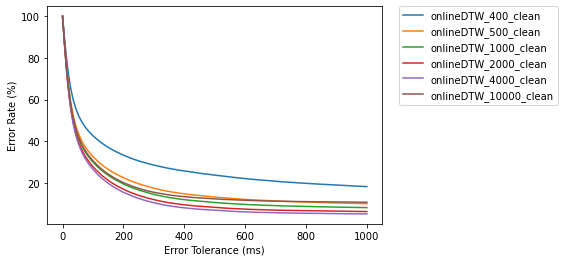

In [39]:
plot_multiple_roc(errRates, toPlot)

### Histogram of selected error rates

In [40]:
def plot_grouped_histogram1(errRates, basenames, tols):  
    # Histogram grouped by tolerance
    
    # first construct DataFrame
    data = []
    for i, system in enumerate(basenames):
        for tol in tols:
            data.append((system, tol, errRates[i,tol] * 100.0))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error'])
    
    # grouped barplot
    sns.barplot(x="Tolerance", y="Error", hue="System", data=df)
    plt.xlabel("Tolerance (ms)", size=14)
    plt.ylabel("Error Rate", size=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    return

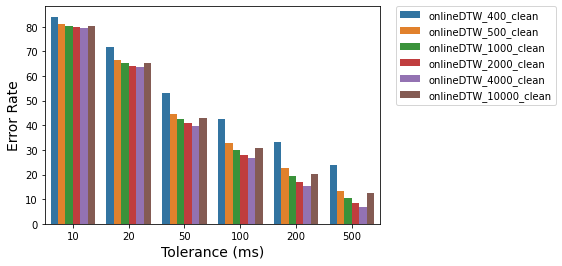

In [41]:
tols = [10, 20, 50, 100, 200, 500] # in msec
plot_grouped_histogram1(errRates, toPlot, tols)

### Final results plot for paper

This one is touched up to look nicer.

In [ ]:
def plot_grouped_histogram1(errRates_bars, errRates_dots, basenames, tols, savefile = None):  
    # Histogram grouped by tolerance
    
    # first construct DataFrame
    data = []
    for i, system in enumerate(basenames):
        for tol in tols:
            data.append((system, tol, errRates[i,tol] * 100.0))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error'])
    
    # grouped barplot (DTW & WSDTW)
    sns.barplot(x="Tolerance", y="Error", hue="System", data=df)
    plt.xlabel("Tolerance (ms)", size=14)
    plt.ylabel("Error Rate (%)", size=14)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(loc='upper right')
    
    # overlay dots for SSDTW results
    width_bar = .135
    x_coords = []
    y_coords = []
    for i, tol in enumerate(tols):
        for j in range(errRates_dots.shape[0]):
            x_coords.append(i+(-1.5+j)*width_bar)
            y_coords.append(errRates_dots[j,tol] * 100.0)
    plt.plot(x_coords, y_coords, 'ko', markersize=3)
    
    if savefile:
        plt.savefig(savefile, bbox_inches = 'tight')
    
    return